# Trading Bases

This notebook explores a strategy I employ for profiting from highly predictable patterns that present themselves when prices move below or above established support or resistance levels, respectively. Prices tend to revert back to previous areas of support and resistance, when these dislocations occur. In fact the conditional probability of 
these reversions is above 90%. In a nutshell the strategy is to buy when a demonstrated support level is breached for the first time and sell when a demonstrated resistance level is exceeded for the first time. This strategy is particularly noteworthy for its simplicity and market neutrality.

## Contents 

- [What is a base?](#What-is-a-base?)
- [Features of a base](#Features-of-a-base)
- [Periods of price dislocation](#Periods-of-price-dislocation) 
- [Strategy rules](#Strategy-rules) 
- [Performance](#Performance) 
- [Optimizations](#Optomizations)  

##### Imports

In [161]:
from datetime import datetime as dt, timedelta as td
import json
import time
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
import numpy as np
from scipy.signal import argrelextrema
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)})
from ipywidgets import interact
import ipywidgets as widgets
import qgrid
from exchange import Exchange, change_period_freq
from strategy import get_bases

##### Set up (get price data and caculate bases and their features)

In [2]:
ASSETS = [
    'BTC',
    'ETH',
    'ETC',
    'LTC',
    'ZEC',
    'XRP',
    'EOS',
    'BAT'
]

PERIOD_FREQS = [
    '4H',
    '1D',
    '7D'
]

polo = Exchange('poloniex')
ohlcv_data = []
bases_data = []
for asset in ASSETS:
    print(asset)
    print('-'*50)
    print('Getting trade data...')
    trades = polo.get_ohlcv(asset,'usdt')
    trades['asset'] = asset
    ohlcv_data.append(trades)
    print('Retrieved {} trades.'.format(trades.shape[0]))
    print('-'*50)
    print('Getting bases...')
    for freq in PERIOD_FREQS:
        print('Frequency: {}'.format(freq))
        trades = change_period_freq(trades, freq)
        bases = get_bases(trades, prices_used=['low','high'], from_file=False, save=True)
        bases['frequency'] = freq
        bases_data.append(bases)
    print('='*50)
    
ohlcv_df = pd.concat(ohlcv_data)
bases_df = pd.concat(bases_data)

BTC
--------------------------------------------------
Getting trade data...
Retrieved 135059 trades.
--------------------------------------------------
Getting bases...
Frequency: 4H


getting base info tmp/BTC_4H_BASES.csv
/Users/malcolmmasonrodriguez/Desktop/crypto-analysis/strategy.py:27: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  retested = pd.tslib.NaT if isinstance(breached, pd.tslib.NaTType) else retested


Frequency: 1D


getting base info tmp/BTC_1D_BASES.csv


Frequency: 7D


getting base info tmp/BTC_7D_BASES.csv


ETH
--------------------------------------------------
Getting trade data...
Retrieved 118790 trades.
--------------------------------------------------
Getting bases...
Frequency: 4H


getting base info tmp/ETH_4H_BASES.csv


Frequency: 1D


getting base info tmp/ETH_1D_BASES.csv


Frequency: 7D


getting base info tmp/ETH_7D_BASES.csv


ETC
--------------------------------------------------
Getting trade data...
Retrieved 84728 trades.
--------------------------------------------------
Getting bases...
Frequency: 4H


getting base info tmp/ETC_4H_BASES.csv


Frequency: 1D


getting base info tmp/ETC_1D_BASES.csv


Frequency: 7D


getting base info tmp/ETC_7D_BASES.csv


LTC
--------------------------------------------------
Getting trade data...
Retrieved 133513 trades.
--------------------------------------------------
Getting bases...
Frequency: 4H


getting base info tmp/LTC_4H_BASES.csv


Frequency: 1D


getting base info tmp/LTC_1D_BASES.csv


Frequency: 7D


getting base info tmp/LTC_7D_BASES.csv


ZEC
--------------------------------------------------
Getting trade data...
Retrieved 75827 trades.
--------------------------------------------------
Getting bases...
Frequency: 4H


getting base info tmp/ZEC_4H_BASES.csv


Frequency: 1D


getting base info tmp/ZEC_1D_BASES.csv


Frequency: 7D


getting base info tmp/ZEC_7D_BASES.csv


XRP
--------------------------------------------------
Getting trade data...
Retrieved 134959 trades.
--------------------------------------------------
Getting bases...
Frequency: 4H


getting base info tmp/XRP_4H_BASES.csv


Frequency: 1D


getting base info tmp/XRP_1D_BASES.csv


Frequency: 7D


getting base info tmp/XRP_7D_BASES.csv


EOS
--------------------------------------------------
Getting trade data...
Retrieved 14227 trades.
--------------------------------------------------
Getting bases...
Frequency: 4H


getting base info tmp/EOS_4H_BASES.csv
/usr/local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:73: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/usr/local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:74: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
/usr/local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:73: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/usr/local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:74: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


Frequency: 1D


getting base info tmp/EOS_1D_BASES.csv


Frequency: 7D
BAT
--------------------------------------------------
Getting trade data...


getting base info tmp/EOS_7D_BASES.csv


Retrieved 12190 trades.
--------------------------------------------------
Getting bases...
Frequency: 4H


getting base info tmp/BAT_4H_BASES.csv


Frequency: 1D


getting base info tmp/BAT_1D_BASES.csv


Frequency: 7D


getting base info tmp/BAT_7D_BASES.csv


In [3]:
ohlcv_df.shape

(709293, 7)

In [4]:
bases_df.shape

(19911, 20)

In [109]:
bases_df['prev_trend_to_reversal'] = bases_df.strength_of_prev_trend / bases_df.strength_of_reversal 
bases_df['prev_trend_to_reversal_time'] = bases_df.time_prev_trend_to_created.dt.seconds / bases_df.time_created_to_end.dt.seconds
#bases_df['time_unbreached_to_breached'] = bases_df.time_breached_to_retested / bases_df.time_created_to_breached 



### What is a base?

A base is a more general term for support and resistance, the price levels at which market participants prefer to enter and exit the market. These areas of interest create bounderies that prevent the price of an asset from moving in a particular direction. 

In [28]:
def get_example_base(base_index=0):
    # select base from df based on user input
    example_base = bases_df[
        (bases_df.strength_of_prev_trend>bases_df.strength_of_prev_trend.quantile(.9))
        &(bases_df.strength_of_reversal>bases_df.strength_of_reversal.quantile(.9))
        &(bases_df.index>dt(2018,1,1))
        &(bases_df.is_support)
    ].sort_values('prev_trend_to_reversal', ascending=False).iloc[base_index]
    
    # determine time parameters
    time_buffer = pd.to_timedelta(example_base.frequency)*100
    start =  example_base.prev_trend_start-time_buffer
    end = example_base.reversal_end+time_buffer 
    period = change_period_freq(ohlcv_df[ohlcv_df.asset==example_base.asset][start:end].sort_index(), example_base.frequency)
    
    # derive features to display
    
    
    # plot price
    ax = period[['low','close','high']].plot()

    # plot annotation coordinates 
    
    # plot fill between window 
    #other_bases = bases_df[bases_df.asset==example_base.asset][start:end].sort_index()
    #ax.plot([example_base.name], [example_base.close], marker='o', ms=20)
    #other_bases.price_level.plot()
    ymin, ymax = ax.get_ybound()
    ax.axvline(example_base.name, )
    fill_condition = ((period.index>=example_base.prev_trend_start)&(period.index<=example_base.reversal_end))
    fill_condition = pd.Series(fill_condition, index=period.index)
    ax.fill_between(period.index, 
                    y1=example_base.price_level, 
                    y2=example_base.price_level*(1+example_base.strength_of_reversal),
                    where=fill_condition, alpha=.2)
    return example_base
    

In [29]:
interact(get_example_base, base_index=50)

interactive(children=(IntSlider(value=50, description='base_index', max=150, min=-50), Output()), _dom_classes…

<function __main__.get_example_base(base_index=0)>

In [8]:
b

<function __main__.get_example_base(base_index=0)>

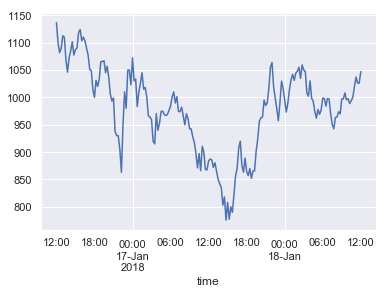

In [9]:
d=dt(2018,1,17,12)

ohlcv_df[ohlcv_df.asset=='ETH'].loc[d-td(hours=24):d+td(hours=24)].close.plot()

In [ ]:
bases_df.loc[dt(2018,1,17,12)].T

In [110]:
bases_df.columns.tolist()

['asset',
 'price_level',
 'is_support',
 'prev_trend_start',
 'reversal_end',
 'strength_of_reversal',
 'strength_of_prev_trend',
 'time_prev_trend_to_created',
 'time_created_to_end',
 'breached',
 'time_created_to_breached',
 'time_breached_to_extrema',
 'breach_extrema_reached',
 'breach_extrema_value',
 'time_breached_to_retested',
 'retested',
 'pct_breach',
 'pct_rebound',
 'pct_of_breach_retraced',
 'frequency',
 'prev_trend_to_reversal',
 'prev_trend_to_reversal_time']

In [ ]:

equity = 13287607 + 777779.38201
debt = (1656742.0515 + 223177.6594) * .145
equity_price = np.arange(0.2, 0.8, .01)

account_value = (equity * equity_price) - debt

plt.plot(equity_price, account_value, marker='o')

In [77]:
def filter_bases(bases, group_types, groups, filters):
	if len(groups)>0:
		group_filter = pd.concat([bases[t].isin(groups) for t in group_types], axis=1).all(axis=1)
		bases = bases[group_filter]
	threshold_filter = []
	for filter_name, filter_range in filters.items():
		is_date = any([isinstance(x, str) and 'D ' in x for x in filter_range])
		filter_range = [pd.to_timedelta(x[1:]) for x in filter_range] if is_date else filter_range
		threshold_filter.append((filter_range[0] < bases[filter_name]) & (bases[filter_name] < filter_range[1]))
	if len(threshold_filter) > 0:
		threshold_filter = pd.concat(threshold_filter, axis=1).all(axis=1)
		bases = bases[threshold_filter]

In [111]:
bases_df.prev_trend_to_reversal.describe()

count    1.095400e+04
mean              inf
std               NaN
min      1.342857e-07
25%      6.547086e-01
50%      1.084170e+00
75%      1.652043e+00
max               inf
Name: prev_trend_to_reversal, dtype: float64

In [204]:
def get_order_book(asset, strength_of_prev_trend, strength_of_reversal, prev_trend_to_reversal, ):
    df = bases_df[
        (bases_df.asset==asset)
        &(bases_df.strength_of_reversal>strength_of_reversal)
        &(bases_df.strength_of_prev_trend>strength_of_prev_trend)
        &(bases_df.prev_trend_to_reversal>prev_trend_to_reversal)
    ]
    grouped = df.groupby([
        df.price_level.round(),
        df.is_support,
        ((1*~df.breached.isna()) + (1*~df.retested.isna())).map({0: 'not breached', 1: 'breached', 2: 'retested'})
    ])
    phases = grouped.count().price_level.unstack()
    totals = phases.sum(axis=1)#.unstack()
    for col in phases.columns:
        phases[col] = (phases[col] / totals)#.rank(pct=True)
    phases['total'] = totals.rank(pct=True)
    phases['prob'] = (phases.breached * phases.total).rank(pct=True)
    phases['prob'] = phases.prob / phases.prob.sum()
    print(phases.prob.sum())
    phases.reset_index(1).prob.plot()
    return phases[~phases.breached.isna()].fillna('')

In [205]:
interact(get_order_book, 
         asset=bases_df.asset.unique(), 
         strength_of_prev_trend=np.arange(0, bases_df.strength_of_prev_trend.quantile(.8), .01),
         strength_of_reversal=np.arange(0, bases_df.strength_of_reversal.quantile(.8), .01),
         prev_trend_to_reversal=np.arange(0, bases_df.prev_trend_to_reversal.quantile(.8), .1)
)


interactive(children=(Dropdown(description='asset', options=('BTC', 'ETH', 'ETC', 'LTC', 'ZEC', 'XRP', 'EOS', …

<function __main__.get_order_book(asset, strength_of_prev_trend, strength_of_reversal, prev_trend_to_reversal)>

In [220]:
date = dt(2018,12,20)
df = bases_df[
    (bases_df.asset=='ETC')
    &(bases_df.strength_of_reversal>0.0)
]
grouped = df.groupby([
    df.price_level.round(1),
    df.is_support,
    ((1*~df.breached.isna()) + (1*~df.retested.isna())).map({0: 'not breached', 1: 'breached', 2: 'retested'})
])
phases = grouped.count().price_level.unstack()
totals = phases.sum(axis=1)#.unstack()
for col in phases.columns:
    phases[col] = (phases[col] / totals)#.rank(pct=True)
phases['count'] = totals#.rank(pct=True)
orderbook_stats = phases[~phases.breached.isna()]
orderbook_stats.fillna('')

grouped = df.groupby([
    df.price_level.round(1),
    df.is_support,
    #((1*~df.breached.isna()) + (1*~df.retested.isna())).map({0: 'not breached', 1: 'breached', 2: 'retested'})
])

desc = grouped.describe()
averages = grouped.mean()


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:3768: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


In [223]:
desc.loc[orderbook_stats.index].rank(pct=True)

prev_trend_to_reversal                                \
                                        count      mean       std       min   
price_level is_support                                                        
1.1         False                    0.938462  0.966102  0.979167  0.016949   
1.3         False                    1.000000  0.508475  0.479167  0.406780   
1.4         False                    0.984615  0.661017  0.812500  0.050847   
1.5         False                    0.969231  0.898305  0.937500  0.254237   
1.7         False                    0.600000  0.813559  0.854167  0.220339   
1.8         False                    0.769231  0.949153  0.958333  0.322034   
1.9         False                    0.384615  0.355932  0.666667  0.525424   
2.0         False                    0.861538  0.711864  0.583333  0.796610   
2.2         False                    0.600000  0.728814  0.750000  0.728814   
2.3         False                    0.769231  0.644068  0.770833  0.389831   
2.4         False                    0.184615  0.288136       NaN  0.711864   
2.5         False                    0.384615  0.915254  0.895833  0.694915   
2.7         False                    0.953846  0.542373  0.562500  0.203390   
2.8         False                    0.900000  0.491525  0.375000  0.644068   
3.0         False                    0.184615  0.779661       NaN  0.949153   
3.1         False                    0.053846       NaN       NaN       NaN   
3.2         False                    0.184615  0.864407       NaN  0.966102   
3.8         False                    0.600000  0.169492  0.270833  0.305085   
3.9         False                    0.600000  0.559322  0.312500  0.661017   
4.1         False                    0.184615  0.152542       NaN  0.576271   
4.2         False                    0.184615  0.983051       NaN  1.000000   
5.0         True                     0.384615  0.762712  0.250000  0.864407   
5.8         True                     0.600000  0.186441  0.208333  0.288136   
6.9         True                     0.600000  0.016949  0.125000  0.033898   
7.0         True                     0.600000  0.118644  0.104167  0.423729   
7.1         True                     0.184615  0.694915       NaN  0.915254   
7.2         True                     0.184615  0.881356       NaN  0.983051   
7.4         True                     0.384615  0.610169  0.791667  0.491525   
7.5         True                     0.184615  0.677966       NaN  0.898305   
8.1         True                     0.184615  0.033898       NaN  0.508475   
8.4         True                     0.384615  0.322034  0.020833  0.762712   
8.8         True                     0.053846       NaN       NaN       NaN   
9.0         True                     0.600000  0.847458  0.645833  0.881356   
9.1         True                     0.769231  0.389831  0.708333  0.169492   
9.5         True                     0.861538  0.593220  0.437500  0.593220   
9.6         True                     0.600000  0.457627  0.687500  0.101695   
10.1        True                     0.384615  0.627119  0.354167  0.830508   
12.0        True                     0.769231  0.050847  0.041667  0.457627   
12.3        True                     0.900000  0.237288  0.416667  0.338983   
12.4        True                     0.861538  1.000000  1.000000  0.474576   
12.5        True                     0.384615  0.406780  0.729167  0.355932   
12.9        True                     0.384615  0.135593  0.604167  0.084746   
13.0        True                     0.923077  0.474576  0.541667  0.135593   
13.8        True                     0.384615  0.220339  0.625000  0.237288   
13.9        True                     0.600000  0.305085  0.520833  0.559322   
15.5        True                     0.600000  0.796610  0.833333  0.677966   
15.8        True                     0.769231  0.423729  0.500000  0.440678   
16.3        True                     0.769231  0.203390  0.291667  0.1525

In [149]:
averages = grouped.median().unstack()
averages.loc[orderbook_stats.index]

price_level                            \
                            breached not breached     retested   
price_level is_support                                           
300.0       False         296.975055          NaN   267.000000   
400.0       False         447.500000          NaN   419.470355   
700.0       False         676.000000          NaN   703.858224   
1100.0      False        1107.957109          NaN  1078.000000   
1300.0      False        1277.255000          NaN          NaN   
1400.0      False        1365.000000          NaN  1365.000000   
2400.0      False        2400.000000          NaN          NaN   
2700.0      False        2720.000000          NaN  2709.180312   
2900.0      False        2910.500000          NaN          NaN   
3600.0      True         3635.008042       3640.0  3620.500000   
5100.0      True         5100.000000          NaN          NaN   
5200.0      True         5151.000000          NaN          NaN   
5400.0      True         5398.265000          NaN          NaN   
5600.0      True         5625.547539          NaN          NaN   
5800.0      True         5768.275651          NaN  5755.000000   
6000.0      True         6012.621204          NaN          NaN   
6100.0      True         6121.938397          NaN          NaN   
6200.0      True         6214.630805          NaN          NaN   
6300.0      True         6304.484658          NaN  6279.679464   
14100.0     True        14083.911359          NaN          NaN   

                       strength_of_reversal                         \
                                   breached not breached  retested   
price_level is_support                                               
300.0       False                  0.276756          NaN  0.125490   
400.0       False                  0.141514          NaN  0.123365   
700.0       False                  0.314869          NaN  0.148459   
1100.0      False                  0.132686          NaN  0.166809   
1300.0      False                  0.242666          NaN       NaN   
1400.0      False                  0.348725          NaN  0.267399   
2400.0      False                  0.235417          NaN       NaN   
2700.0      False                  0.202819          NaN  0.199058   
2900.0      False                  0.147932          NaN       NaN   
3600.0      True                   0.121043     0.153846  0.180234   
5100.0      True                   0.125080          NaN       NaN   
5200.0      True                   0.301104          NaN       NaN   
5400.0      True                   0.127986          NaN       NaN   
5600.0      True                   0.151173          NaN       NaN   
5800.0      True                   0.207163          NaN  0.155517   
6000.0      True                   0.508493          NaN       NaN   
6100.0      True                   0.250854          NaN       NaN   
6200.0      True                   0.104404          NaN       NaN   
6300.0      True                   0.213158          NaN  0.185492   
14100.0     True                   0.225305          NaN       NaN   

                       strength_of_prev_trend                         \
                                     breached not breached  retested   
price_level is_support                                                 
300.0       False                    0.270033          NaN  0.106383   
400.0       False                    0.076104          NaN  0.087781   
700.0       False                    0.035168          NaN  0.146720   
1100.0      False                    0.121489          NaN       NaN   
1300.0      False                    0.154808          NaN       NaN   
1400.0      False                         NaN          NaN  0.165634   
2400.0      False                    0.099404          NaN       NaN   
2700.0      False                    0.070357          NaN  0.028153   
2900.0      False                    0.518882          NaN       NaN   
3600.0      True               

In [153]:
describe = grouped.describe()

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:3768: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


In [156]:
describe.unstack().loc[orderbook_stats.index]

prev_trend_to_reversal                                  \
                                        count                            mean   
                                     breached not breached retested  breached   
price_level is_support                                                          
300.0       False                         4.0          NaN      5.0  1.255806   
400.0       False                         1.0          NaN      5.0  0.566065   
700.0       False                         1.0          NaN      3.0  0.116960   
1100.0      False                         2.0          NaN      0.0  0.969832   
1300.0      False                         2.0          NaN      NaN  0.604274   
1400.0      False                         0.0          NaN      1.0       NaN   
2400.0      False                         1.0          NaN      NaN  0.422249   
2700.0      False                         1.0          NaN      2.0  0.346896   
2900.0      False                         2.0          NaN      NaN  3.562477   
3600.0      True                          0.0          1.0      2.0       NaN   
5100.0      True                          1.0          NaN      NaN  0.776311   
5200.0      True                          3.0          NaN      NaN  0.663325   
5400.0      True                          1.0          NaN      NaN  1.114400   
5600.0      True                          2.0          NaN      NaN  0.645314   
5800.0      True                          2.0          NaN      1.0  0.906056   
6000.0      True                          1.0          NaN      NaN  0.721546   
6100.0      True                          2.0          NaN      NaN  1.022909   
6200.0      True                          1.0          NaN      NaN  0.563900   
6300.0      True                          1.0          NaN      1.0  0.077732   
14100.0     True                          1.0          NaN      NaN  0.390015   

                                                                      \
                                                    std                
                       not breached  retested  breached not breached   
price_level is_support                                                 
300.0       False               NaN  0.861827  1.252363          NaN   
400.0       False               NaN  0.561091       NaN          NaN   
700.0       False               NaN  1.277130       NaN          NaN   
1100.0      False               NaN       NaN  0.962059          NaN   
1300.0      False               NaN       NaN  0.587549          NaN   
1400.0      False               NaN  0.619425       NaN          NaN   
2400.0      False               NaN       NaN       NaN          NaN   
2700.0      False               NaN  0.214033       NaN          NaN   
2900.0      False               NaN       NaN  0.360838          NaN   
3600.0      True           2.919492  0.843372       NaN          NaN   
5100.0      True                NaN       NaN       NaN          NaN   
5200.0      True                NaN       NaN  0.506920          NaN   
5400.0      True                NaN       NaN       NaN          NaN   
5600.0      True                NaN       NaN  0.129113          NaN   
5800.0      True                NaN  0.763152  0.300489          NaN   
6000.0      True                NaN       NaN       NaN          NaN   
6100.0      True                NaN       NaN  0.668277          NaN   
6200.0      True                NaN       NaN       NaN          NaN   
6300.0      True                NaN  0.366427       NaN          NaN   
14100.0     True                NaN       NaN       NaN          NaN   

                                                 ...         \
                                       min       ...          
                        retested  breached       ...          
price_level is_support                           ...          
300.0       False       0.275690  0.135938       ...          
400.0       False       0.261611  

In [74]:
#phases = phases.reset_index() 
#phases.sort_values(['is_support','price_level'])
#phases[phases.is_support]


,,breached,not breached,retested
price_level,is_support,,,
0.0,False,0.112903,NaN,0.887097
1000.0,False,0.241645,NaN,0.758355
2000.0,False,0.107143,NaN,0.892857
3000.0,False,0.259740,NaN,0.740260
4000.0,True,0.052083,0.020833,0.927083
5000.0,True,0.500000,NaN,0.500000
6000.0,True,0.328767,NaN,0.671233
7000.0,True,0.023438,NaN,0.976562
8000.0,True,0.078947,NaN,0.921053


In [65]:
phases.reset_index('price_level',)

KeyError: 'Level price_level must be same as name (None)'

In [ ]:
grouped.breached.count().plot(alpha=.6)
grouped.retested.count().plot(alpha=.2)

In [ ]:
grouped.strength_of_prev_trend.std() / grouped.strength_of_prev_trend.mean()

In [ ]:
desc = grouped[columns].describe()

In [ ]:
columns = [
        'asset',
        'price_level',
        'is_support',
        'prev_trend_start',
        'reversal_end',
        'strength_of_reversal',
        'strength_of_prev_trend',
        'time_prev_trend_to_created',
        'time_created_to_end',
        'breached',
        'time_created_to_breached',
        'time_breached_to_extrema',
        'breach_extrema_reached',
        'breach_extrema_value',
        'time_breached_to_retested',
        'retested',
        'pct_breach',
        'pct_rebound',
        'pct_of_breach_retraced',
    ]

desc.T

In [ ]:
(desc.time_['mean'] / desc.time_created_to_end['mean']).plot(kind='bar')#['count'].plot()


In [ ]:
qgrid.show_grid(grouped.describe())

In [ ]:
bases_df.head().low.round(-2)

Let's say that sentiment around an asset is poor, such that holders want to ditch it before the price goes down further (important concept to understand, prices are reflexive - buying induces more buying and selling more selling). Eventually the price falls so low that people are willing to come in and buy at the relatively discounted price. The volume of demand at some point begins to countervail that of the sellers and the price stops moving lower. Support has been found. At this inflection point, we can clearly see that there are buyers and the magnituded of the subsequent reversal trend should demonstrate how many are present. 

As the price bounces off of the demonstrated support level it will eventually lose momentum and reach a level that is attractive for holders to realize gains. When buyers are exhausted by the preponderance of sellers the prices will reverse course, with the intensity of the reversion revealing the number of sellers. 

Thus far the market has established a base of support and base of resistance. If all of the new entrants from the time that suppport was formed to the point at which momentum abated are simply speculators (meaning traders just looking to make a quick buck and not hold on for the long term) then they will be more than willing to bring the price all the way back to previous support eagerly taking profit all the way down.  

### Important characteristics

### Periods of price dislocation

### Strategy rules

### Performance

### Optimizations